In [1]:
from progressbar import progressbar
from help import helper
from skimage.feature import local_binary_pattern, hog
from joblib import dump, load
from sklearn.model_selection import KFold
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
import os
import time

warnings.filterwarnings('ignore')

### Target

In [7]:
expressions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

### JAFFE (Japanese Female Facial Expression) => Jepang | Asia Timur

In [10]:
dataset = np.loadtxt('dataset/jaffe.csv', delimiter=';', dtype='<U')
dataset_name = 'jaffe'
dataset.shape

(213, 2)

### KDEF (Karolinska Directed Emotional Faces) => Swedia | Eropa Utara

In [14]:
dataset = np.loadtxt('dataset/kdef.csv', delimiter=';', dtype='<U')
dataset_name = 'kdef'
dataset.shape

(980, 2)

### CK+ (Extended Cohn-Kanade) => Pennsylvania | Amerika Serikat

In [16]:
dataset = np.loadtxt('dataset/ck+.csv', delimiter=';', dtype='<U')
dataset_name = 'ck+'
dataset.shape

(1563, 2)

### CAS-PEAL (Chinese Academy of Sciences - Pose, Expression, Accessory, and Lighting) => Cina | Asia Timur

In [18]:
dataset = np.loadtxt('dataset/caspeal.csv', delimiter=';', dtype='<U')
dataset_name = 'caspeal'
dataset.shape

(2171, 2)

### FacesDB => Brazil | Amerika Serikat

In [20]:
dataset = np.loadtxt('dataset/facesdb.csv', delimiter=';', dtype='<U')
dataset_name = 'facesdb'
dataset.shape

(252, 2)

### Hijrah => Indonesia | Asia Tenggara

In [22]:
dataset = np.loadtxt('dataset/hijrah.csv', delimiter=';', dtype='<U')
dataset_name = 'hijrah'
dataset.shape

(2569, 2)

### NVIE (Natural Visible and Infrared facial Expression) => Cina | Asia Timur

In [24]:
dataset = np.loadtxt('dataset/nvie.csv', delimiter=';', dtype='<U')
dataset_name = 'nvie'
dataset.shape

(3977, 2)

### Test

In [13]:
dataset = np.loadtxt('dataset/test.csv', delimiter=';', dtype='<U')
dataset_name = 'test'
dataset.shape

(277, 2)

### Deteksi Wajah

In [ ]:
s = 128
c = 0
feature = 'haar'
for path, target in progressbar(dataset, prefix=f'{dataset_name} detecting face...'):
    img = cv2.imread(path)
    img = helper.dresize(img, 256)
    faces = helper.face_detection(img, feature=feature, scaleFactor=1.175)
    for x1, x2, y1, y2, w, h, wide in faces:
        im = img[y1:y2,x1:x2]
        im = helper.crop_square(im, side=0, size=(s, s))
        cv2.imwrite(f'dataset/dump/{dataset_name}/{target}_{c:05d}.t.png', im)
        c += 1

### Ekstraksi Fitur

In [ ]:
feature = 'haar'
dpaths = os.listdir(f'dataset/dump/{feature}')
helper.remove(dpaths, 'desktop.ini')
scores = {}
for dpath in dpaths:
    vectors = []
    images = os.listdir(f'dataset/dump/{feature}/{dpath}')
    helper.remove(images, 'desktop.ini')
    scores[dpath] = {'jumlah':np.loadtxt(f'dataset/{dpath}.csv', delimiter=';', dtype='<U').shape[0], 't':0, 'f':0}
    for img in progressbar(images, prefix=f'preprocessing {dpath}  '):
        success = True if img.split('.')[1] == 't' else False
        if success:
            target = img.split('_')[0]
            img = cv2.imread(f'dataset/dump/{feature}/{dpath}/{img}', cv2.IMREAD_GRAYSCALE)
            vector = []
            vector.extend(hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)))
            vector.extend(helper.lbph(local_binary_pattern(img, P=8, R=1), size=(26, 26), normed=True))
            vector.append(expressions.index(target))
            vectors.append(vector)
            scores[dpath]['t'] += 1
        else:
            scores[dpath]['f'] += 1
    vectors = np.array(vectors)
    np.random.shuffle(vectors)
    dump(vectors, f'dataset/vectors/ori/{dpath}.jlb')
    del vectors
helper.savejson(f'score/facedetection_{feature}.json', scores)

### Akurasi face detection

In [9]:
scores = helper.loadjson('score/facedetection_haar.json')
jumlah = 0
t = 0
f = 0
meanacc = []
for key in scores.keys():
    print(key)
    print(f" jumlah  : {scores[key]['jumlah']} | terdeteksi benar : {scores[key]['t']} | terdeteksi salah : {scores[key]['f']}")
    acc = (scores[key]['jumlah'] - ((scores[key]['jumlah'] - scores[key]['t']) + scores[key]['f'])) / scores[key]['jumlah'] * 100
    print(f" akurasi : {acc:0.02f}%")
    jumlah += scores[key]['jumlah']
    t += scores[key]['t']
    f += scores[key]['f']
    meanacc.append(acc)
meanacc = np.array(meanacc).mean()
print('all')
print(f' jumlah  : {jumlah} | terdeteksi benar : {t} | terdeteksi salah : {f}')
print(f' akurasi : {(jumlah - (jumlah - t + f)) / jumlah * 100:0.02f}%')

caspeal
 jumlah  : 2171 | terdeteksi benar : 2156 | terdeteksi salah : 27
 akurasi : 98.07%
ck+
 jumlah  : 1563 | terdeteksi benar : 1562 | terdeteksi salah : 0
 akurasi : 99.94%
facesdb
 jumlah  : 252 | terdeteksi benar : 252 | terdeteksi salah : 2
 akurasi : 99.21%
hijrah
 jumlah  : 2569 | terdeteksi benar : 2568 | terdeteksi salah : 67
 akurasi : 97.35%
jaffe
 jumlah  : 213 | terdeteksi benar : 213 | terdeteksi salah : 0
 akurasi : 100.00%
kdef
 jumlah  : 980 | terdeteksi benar : 980 | terdeteksi salah : 0
 akurasi : 100.00%
nvie
 jumlah  : 3977 | terdeteksi benar : 3954 | terdeteksi salah : 7
 akurasi : 99.25%
all
 jumlah  : 11725 | terdeteksi benar : 11685 | terdeteksi salah : 103
 akurasi : 98.78%


### Gabung Semua Dataset

In [10]:
dpath = [s for s in os.listdir('dataset/vectors/ori') if 'jlb' in s]
helper.remove(dpath, 'all.jlb')
all_dataset = []
for dataset in dpath:
    ds = load(f'dataset/vectors/ori/{dataset}')
    all_dataset.extend(ds)
all_dataset = np.array(all_dataset)
np.random.shuffle(all_dataset)
dump(all_dataset, f'dataset/vectors/ori/all.jlb')
print(all_dataset.shape)
del ds
del all_dataset

(11685, 14501)


### Ilustrasi

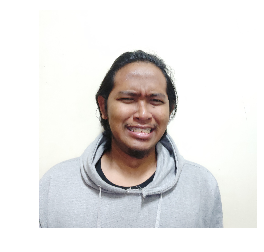

In [20]:
img = cv2.imread('dataset/raw/hijrah/002 P002/disgust/IMG_20190323_212727_2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

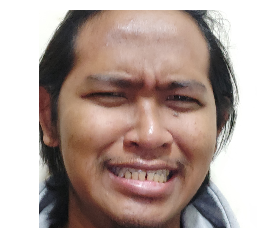

In [7]:
img = cv2.imread('dataset/raw/hijrah/002 P002/disgust/IMG_20190323_212727_2.jpg')
faces = helper.face_detection(img)
x1, x2, y1, y2, w, h, wide = faces[0]
img = img[y1:y2,x1:x2]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

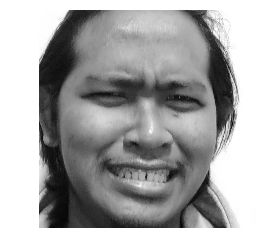

In [9]:
img = cv2.imread('dataset/raw/hijrah/002 P002/disgust/IMG_20190323_212727_2.jpg')
faces = helper.face_detection(img)
x1, x2, y1, y2, w, h, wide = faces[0]
img = img[y1:y2,x1:x2]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.axis('off')
plt.imshow(img, cmap='gray')

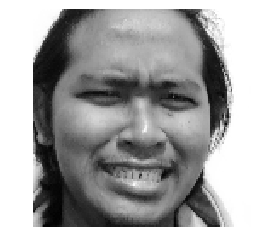

In [14]:
img = cv2.imread('dataset/raw/hijrah/002 P002/disgust/IMG_20190323_212727_2.jpg')
faces = helper.face_detection(img)
x1, x2, y1, y2, w, h, wide = faces[0]
img = img[y1:y2,x1:x2]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = helper.crop_square(img, side=0, size=(128, 128))
plt.axis('off')
plt.imshow(img, cmap='gray')

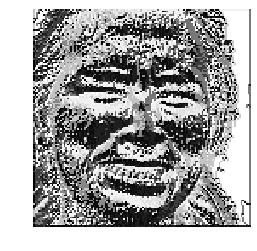

In [15]:
img = cv2.imread('dataset/raw/hijrah/002 P002/disgust/IMG_20190323_212727_2.jpg')
faces = helper.face_detection(img)
x1, x2, y1, y2, w, h, wide = faces[0]
img = img[y1:y2,x1:x2]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = helper.crop_square(img, side=0, size=(128, 128))
img = local_binary_pattern(img, 8, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
# helper.lbph(img, size=(26, 26), normed=True).shape